# Table of Content
1. [Text Cleaning](#textcleaning)
2. [Text Preprocessing](#textpreprocessing)
3. [EDA](#EDA)
4. [Feature Engineering](#featureengineering)

In [40]:
%time
import os
import sys
import time
import random
import string
from ast import literal_eval
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import pandas as pd
import sklearn

# libraries for text cleaning
import contractions
from bs4 import BeautifulSoup
from textblob import TextBlob
from spellchecker import SpellChecker
#from profanity_check import predict

# libraries and packages for text (pre-)processing 
import string
import re
import nltk

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import *
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag_sents
from nltk.tokenize import sent_tokenize

##libraries and packages for EDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Wall time: 0 ns


In [2]:
train_df = pd.read_csv("Data/train.csv")
print(train_df.shape)
train_df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<a id="textcleaning"></a>
# 1. Text Cleaning

## Convert to Lower Case

We convert all letters to lower case to prepare for the following steps of text cleaning. Exceptional cases such as capital abbreviation will be solved by replacing typos, slang, acronyms or informal abbreviations technique in the subsquent steps.

In [3]:
train_df["clean_text"] = train_df["comment_text"].apply(lambda x: x.lower())
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"""\nmore\ni can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


## Expand Contractions


Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe. Removing contractions helps contribute to text standardization. We use contractions package to expand contractions.

In [4]:
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: contractions.fix(x))

In [5]:
# check if expand contractions works
print("Original text: \n", train_df["comment_text"][2])
print("Clean text: \n", train_df["clean_text"][2])

Original text: 
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Clean text: 
 hey man, i am really not trying to edit war. it is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.


## Remove Noise

Remove unnecessary characters or punctuation such as URLs, HTML tags, non-ASCII characters, or other special characters 

### Remove URL

In [6]:
# replace URL with space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', ' ', x))

###  Remove Non-ASCI Characters

In [7]:
# replace Non_ASCI characters with space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r'[^\x00-\x7f]', ' ', x))

###  Remove Special Characters

In [8]:
regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        u"\ufe0f"  # dingbats
        "]+", flags = re.UNICODE)

In [9]:
# replace special characters with space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: regrex_pattern.sub(' ', x))

In [10]:
# check if special characters are removed
print("Original text: \n", train_df["comment_text"][143])
print("Clean text: \n", train_df["clean_text"][143])

Original text: 
 "P.S. It's not polite to talk to people behind their backs, please remove your comments from Mrph's talk page.

Vaughan
You're right; I went to check your previous edit and found a page on the Marvel site that spelled it ""Vaughn"", but now I am finding many more that spell it correctly. Thanks for the edits.   (☎☓) 

"
Clean text: 
 "p.s. it is not polite to talk to people behind their backs, please remove your comments from mrph's talk page.

vaughan
you are right; i went to check your previous edit and found a page on the marvel site that spelled it ""vaughn"", but now i am finding many more that spell it correctly. thanks for the edits.   (  ) 

"


### Remove HTML Tag (BeautifulSoup not really useful? merely remove space?)

In [11]:
cleaned_text = train_df["clean_text"].apply(lambda x: BeautifulSoup(str(x)).get_text())

In [12]:
text_changed = cleaned_text!=train_df["clean_text"]

In [13]:
[i for i, x in enumerate(text_changed) if x][:10]

[569, 1403, 2028, 2189, 3458, 3500, 3687, 4001, 4030, 4090]

In [14]:
train_df["clean_text"][228]

'   heritage from village           in macedonian          . sources claim that the village was pure slavic.'

In [15]:
cleaned_text[228]

'   heritage from village           in macedonian          . sources claim that the village was pure slavic.'

In [16]:
# replace HTML tag with space
html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(html, " ", x))

###  Remove Extra Space

In [17]:
# replace \n with space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub('\n', ' ', x))

In [18]:
# replace \r\n with space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub('\r\n', ' ', x))

In [19]:
# remove extra space
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(' +', ' ', x))

## Replace Common Slangs

Slang, acronyms or informal abbreviations should be replaced with formal English. The list of common slangs used in Tweets takes reference from https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing.

In [20]:
# read abbreviation.csv
abbreviations = pd.read_csv('Data/abbreviations.csv')
abbreviations.head()

,abbreviation,translation
0,$,dollar
1,€,euro
2,4ao,for adults only
3,a.m,before midday
4,a3,anytime anywhere anyplace


In [21]:
# convert the data frame to a dictionary
abbreviations_dict = dict(zip(abbreviations.abbreviation, abbreviations.translation))

In [22]:
# define a helper function to replace the abbreviations
def convert_abbrev(text):
    # create a pattern of all abbreviations and make sure they are not part of a longer word
    abbreviations_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in abbreviations_dict.keys()) + r')(?!\w)')
    # replace an abbreviation with its translation
    text = abbreviations_pattern.sub(lambda x: abbreviations_dict[x.group()], text)
    return text

In [23]:
# replace the slangs
train_df["clean_text"] = train_df["clean_text"].apply(convert_abbrev)

In [24]:
# check if slangs are replaced
print("Original text: \n", train_df["comment_text"][1])
print("Clean text: \n", train_df["clean_text"][1])

Original text: 
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Clean text: 
 d'aww! he matches this background colour i am seemingly stuck with. thanks. (talk) 21:51, january 11, 2016 (coordinated universal time)


## Spelling Correction

We should correct the misspellings in the text. Both SpellChecker and TextBlob provide such functions, and we would like to compare their performance.

In [25]:
# select random texts from clean_text
length = len(train_df["clean_text"])
random_num = random.sample(range(length), 100)
random_text = train_df["clean_text"][random_num]

In [26]:
# using TextBlob package
start_time1 = time.time()
random_text.apply(lambda x: TextBlob(x).correct())
print("--- %s seconds ---" % (time.time() - start_time1))

--- 57.317009925842285 seconds ---


In [27]:
# using SpellChecker package
start_time2 = time.time()
random_text.apply(lambda x: SpellChecker().correction(x))
print("--- %s seconds ---" % (time.time() - start_time2))

--- 11.802759170532227 seconds ---


Randomly select 100 texts and apply spelling correction functions on them. Comparing the execution time of 2 different packages, SpellChecker is much faster than TextBlob. Considering we are using a large-scale dataset, SpellChecker is preferred.

In [28]:
def correct_spelling(text):
    start_time = time.time()
    cleaned_text = []
    spellchecker = SpellChecker()
    for i in range(text.shape[0]):
        if i%100==0:
            print(f'{i}-th text is being processed')
        cleaned_text.append(spellchecker.correction(text[i]))
    print("--- %s seconds ---" % (time.time() - start_time))
    return cleaned_text

In [29]:
cleaned_text = correct_spelling(train_df["clean_text"][:1001])

0-th text is being processed
100-th text is being processed
200-th text is being processed
300-th text is being processed
400-th text is being processed
500-th text is being processed
600-th text is being processed
700-th text is being processed
800-th text is being processed
900-th text is being processed
1000-th text is being processed
--- 66.39581418037415 seconds ---


In [30]:
train_df["clean_text"][:1001].index[cleaned_text!=train_df["clean_text"][:1001]]

Int64Index([ 62,  89, 101, 173, 175, 211, 217, 223, 226, 241, 250, 254, 259,
            268, 276, 299, 320, 323, 376, 381, 397, 408, 423, 448, 465, 470,
            504, 545, 592, 627, 632, 646, 715, 743, 758, 787, 806, 807, 814,
            823, 831, 844, 852, 874, 877, 883, 897, 899, 913, 923, 947, 971],
           dtype='int64')

In [31]:
train_df["clean_text"][971]

'. fu ck ing trollreasons'

In [32]:
cleaned_text[971]

However, many corrections do not make sense, and may omit some useful information. We decided not to use established package to perform spelling correction.

## Remove Punctuations

We remove punctuations from the text as the final step of text cleaning.

In [33]:
# # remove punctuations
#train_df["clean_text"] = train_df["clean_text"].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
r = re.compile(r'''([!#$%&'()*+,./:;<=>?@[\]^_`{|}~-])[!"#$%&'()*+,./:;<=>?@[\]^_`{|}~-]+''')
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: r.sub(r'\1', x))

In [34]:
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i am ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i am really not trying to edit war. i..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" more i cannot make any real suggestions on i..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,""":and for the second time of asking, when your..."
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,you should be ashamed of yourself that is a ho...
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,"spitzer umm, there is no actual article for pr..."
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,and it looks like it was actually you who put ...


In [35]:
train_df.drop('comment_text', axis=1).to_csv('Data/cleaned_train.csv', index=False)

<a id="textpreprocessing"></a>
# 2. Text Preprocessing

In [36]:
#cleaned_df = pd.read_csv("/cleaned_train.csv")
cleaned_df = pd.read_csv("Data/cleaned_train.csv")
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


## Tokenization (NLTK has a package specially catered to tokenizing tweets)

In [37]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
cleaned_df['text_tokenized'] = cleaned_df['clean_text'].apply(tt.tokenize)

In [38]:
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my..."
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo..."
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance..."


## Remove Stop Words (or/and Frequent words/ Rare words)

### Stop Words Removal

In [39]:
from nltk.corpus import stopwords

#review all stop words in the library
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [40]:
#remove stop words from tokenized text
stop_words = stopwords.words('english')

def remove_stopwords(row):
    # check in lowercase 
    t = [token for token in row['text_tokenized'] if token.lower() not in stop_words]
    text = ' '.join(t)    
    return pd.Series([text])    #for stemming

cleaned_df[['text_no_stop_words']] = cleaned_df.apply(remove_stopwords, axis = 1)


cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_no_stop_words
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...",d'aww ! matches background colour seemingly st...
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","hey man , really trying edit war . guy constan..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...",""" cannot make real suggestions improvement - w..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...",", sir , hero . chance remember page ?"


In [41]:
#drop clean_text and tokenized column
#del cleaned_df['clean_text']
#del cleaned_df['text_tokenized']
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_no_stop_words
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...",d'aww ! matches background colour seemingly st...
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","hey man , really trying edit war . guy constan..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...",""" cannot make real suggestions improvement - w..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...",", sir , hero . chance remember page ?"


## Stemming

We will use Snowball Stemmer to realise stemming. Comparing with Poster Stemmer, it is more efficient and has higher performance. Comparing with Lancaster Stemmer, it is less aggressive and can keep more word meanings for the Semantic Analysis in our later stage. 

In [42]:
stemmer = SnowballStemmer(language = 'english')
def stem_list_of_words(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    stemmed_sent = ' '.join(stemmed_words)  
    return stemmed_sent
        

cleaned_df['stemmed'] = cleaned_df['text_tokenized'].apply(stem_list_of_words)
#del cleaned_df['for_stemming_use']
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_no_stop_words,stemmed
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...,explan whi the edit made under my usernam hard...
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...",d'aww ! matches background colour seemingly st...,d'aww ! he match this background colour i am s...
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","hey man , really trying edit war . guy constan...","hey man , i am realli not tri to edit war . it..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...",""" cannot make real suggestions improvement - w...",""" more i cannot make ani real suggest on impro..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...",", sir , hero . chance remember page ?","you , sir , are my hero . ani chanc you rememb..."


## Part of Speech Tagging (POS Tagging)

In [43]:
def to_word_tokens(sent_tokens):
    word_tokens = [] 
    for sent_token in sent_tokens:
        word_tokens.append(tt.tokenize(sent_token))
    return word_tokens

In [44]:
cleaned_df['for_tagging_use_sent_token'] = cleaned_df['clean_text'].apply(sent_tokenize)
cleaned_df['for_tagging_use_word_token'] = cleaned_df['for_tagging_use_sent_token'].apply(to_word_tokens)
cleaned_df['POS_tagging'] = cleaned_df['for_tagging_use_word_token'].apply(pos_tag_sents)
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_no_stop_words,stemmed,for_tagging_use_sent_token,for_tagging_use_word_token,POS_tagging
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...,explan whi the edit made under my usernam hard...,[explanation why the edits made under my usern...,"[[explanation, why, the, edits, made, under, m...","[[(explanation, NN), (why, WRB), (the, DT), (e..."
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...",d'aww ! matches background colour seemingly st...,d'aww ! he match this background colour i am s...,"[d'aww!, he matches this background colour i a...","[[d'aww, !], [he, matches, this, background, c...","[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ..."
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","hey man , really trying edit war . guy constan...","hey man , i am realli not tri to edit war . it...","[hey man, i am really not trying to edit war.,...","[[hey, man, ,, i, am, really, not, trying, to,...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...",""" cannot make real suggestions improvement - w...",""" more i cannot make ani real suggest on impro...","["" more i cannot make any real suggestions on ...","[["", more, i, cannot, make, any, real, suggest...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...",", sir , hero . chance remember page ?","you , sir , are my hero . ani chanc you rememb...","[you, sir, are my hero., any chance you rememb...","[[you, ,, sir, ,, are, my, hero, .], [any, cha...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,..."


In [45]:
cleaned_df = cleaned_df.drop(columns=['for_tagging_use_sent_token','for_tagging_use_word_token'])
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized,text_no_stop_words,stemmed,POS_tagging
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...,explan whi the edit made under my usernam hard...,"[[(explanation, NN), (why, WRB), (the, DT), (e..."
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[d'aww, !, he, matches, this, background, colo...",d'aww ! matches background colour seemingly st...,d'aww ! he match this background colour i am s...,"[[(d'aww, NN), (!, .)], [(he, PRP), (matches, ..."
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, ,, i, am, really, not, trying, to, ...","hey man , really trying edit war . guy constan...","hey man , i am realli not tri to edit war . it...","[[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, ..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","["", more, i, cannot, make, any, real, suggesti...",""" cannot make real suggestions improvement - w...",""" more i cannot make ani real suggest on impro...","[[("", IN), (more, JJR), (i, JJ), (cannot, NNS)..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, ,, sir, ,, are, my, hero, ., any, chance...",", sir , hero . chance remember page ?","you , sir , are my hero . ani chanc you rememb...","[[(you, PRP), (,, ,), (sir, VB), (,, ,), (are,..."


## Lemmatization

In [46]:
cleaned_df['POS_tagging_flat'] = cleaned_df['POS_tagging'].apply(lambda x: [element for innerList in x for element in innerList])

In [47]:
lemmatizer = WordNetLemmatizer()
cleaned_df['lemmatization'] = cleaned_df['POS_tagging_flat'].apply(lambda x: [lemmatizer.lemmatize(word) for word, tag in x 
                                                                              if ((tag.startswith('JJ') or tag.startswith('NN') or tag.startswith('RB') or tag.startswith('VB')) and (word not in string.punctuation))])

Stemming might not be useful for creating features. Lemmatization based on tagging result has achieved same result as text without stop words. Text_tokenized column, POS tagging result, and lemmatization for future analysis.

In [48]:
del cleaned_df['clean_text']
del cleaned_df['text_no_stop_words']
del cleaned_df['stemmed']
del cleaned_df['POS_tagging']
cleaned_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_tokenized,POS_tagging_flat,lemmatization
0,0000997932d777bf,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[(explanation, NN), (why, WRB), (the, DT), (ed...","[explanation, edits, made, username, hardcore,..."
1,000103f0d9cfb60f,0,0,0,0,0,0,"[d'aww, !, he, matches, this, background, colo...","[(d'aww, NN), (!, .), (he, PRP), (matches, VBZ...","[d'aww, match, colour, i, am, seemingly, stuck..."
2,000113f07ec002fd,0,0,0,0,0,0,"[hey, man, ,, i, am, really, not, trying, to, ...","[(hey, NN), (man, NN), (,, ,), (i, JJ), (am, V...","[hey, man, i, am, really, not, trying, edit, w..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,"["", more, i, cannot, make, any, real, suggesti...","[("", IN), (more, JJR), (i, JJ), (cannot, NNS),...","[more, i, cannot, make, real, suggestion, impr..."
4,0001d958c54c6e35,0,0,0,0,0,0,"[you, ,, sir, ,, are, my, hero, ., any, chance...","[(you, PRP), (,, ,), (sir, VB), (,, ,), (are, ...","[sir, are, hero, chance, remember, page, is]"


In [49]:
cleaned_df.to_csv('Data/processed_train.csv', index=False)

<a id="EDA"></a>
# 3. EDA

In [ ]:
# prevent lists from being converted to strings
processed_df = pd.read_csv('Data/processed_train.csv', 
                           converters={'text_tokenized': literal_eval, 'POS_tagging_flat': literal_eval, 'lemmatization': literal_eval})
processed_df.head()

In [ ]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = processed_df.iloc[:,1:7].sum()

plt.figure(figsize=(15,8))

ax= sns.barplot(x=x.index,y=x.values,palette=palette)
plt.title("Comment Category Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of tweets', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

In [ ]:
# Obtain counts of each class
counts = {
    '0': [],
    '1': [],
}

categories = list(processed_df.columns.values)
categories = categories[1:7]

for c in categories:
    count_occurence_1 = len(processed_df.loc[processed_df[c] == 1])
    count_occurence_0 = len(processed_df.loc[processed_df[c] == 0])
    counts['0'].append(count_occurence_0)
    counts['1'].append(count_occurence_1)

# Plot distribution of comment category
x = np.arange(len(classes))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8))

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Comment Category')
ax.set_title('Distribution of Comment Category')
ax.set_xticks(x + width)
ax.set_xticklabels(categories)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
toxic_comments_count= train_undersampled[train_undersampled[categories].sum(axis=1) > 0]
untoxic_comments_count = train_undersampled[train_undersampled[categories].sum(axis=1) == 0]

print("Total number of comments = ",len(processed_df))
print("Number of untoxic comments = ",untoxic_comments_count)
print("Number of comments with toxic labels =",(len(processed_df)-untoxic_comments_count))

print(f"{round(untoxic_comments_count/len(processed_df),3)} % percentage of rows contains only zeros in training data")

count = pd.DataFrame(dict(
    types = ['toxic', 'untoxic'],
    counts = [toxic_comments_count, untoxic_comments_count]
))

sns.barplot(data=count, x='types',y='counts')

From the plot above, we also observe that the dataset is highly imbalanced. This fact is also supported by the the big number of difference in toxic and untoxic comment (about 90% of training data is untoxic). Therefore, in the later part of the project, we will perform undersampling on the training set. 

In [ ]:
# Function to do undersampling

def undersample(train, categories):
    train_toxic_comments = train[train[categories].sum(axis=1) > 0]
    train_untoxic_comments = train[train[categories].sum(axis=1) == 0]

    train_toxic_count, train_untoxic_count = len(train_toxic_comments), len(train_untoxic_comments)

    # Under-sample class untoxic
    train_untoxic_under = train_untoxic_comments.sample(n = train_toxic_count, random_state = 0)

    # Merge undersampled class 0 and original class 1
    train_under = pd.concat([train_untoxic_under, train_toxic_comments], axis = 0)
    return train_under

In [ ]:
train_undersampled = undersample(processed_df, categories)

train_undersampled.shape

In [ ]:
train_toxic_comments = train_undersampled[train_undersampled[categories].sum(axis=1) > 0]
train_clean_comments = train_undersampled[train_undersampled[categories].sum(axis=1) == 0]

count = pd.DataFrame(dict(
    types = ['toxic', 'untoxic'],
    counts = [len(train_toxic_comments), len(train_clean_comments)]
))

sns.barplot(data=count, x='types',y='counts')

In [ ]:
train_undersampled.to_csv('Data/train_undersampled.csv', index=False)

## Top frequent tags (using POS result) 

### Overall data

In [142]:
POS_list = []

for x in processed_df['POS_tagging_flat']:
    POS_list.append(x)

In [143]:
from collections import Counter
from itertools import chain

POS_count = Counter(chain(*POS_list))

In [144]:
POS_frequent_df = pd.DataFrame.from_dict(POS_count, orient='index').reset_index()
POS_frequent_df.columns = ['POS_tags', 'Count']
POS_frequent_df = POS_frequent_df.sort_values(by=['Count'], ascending=False)
POS_frequent_df['Word'] = POS_frequent_df['POS_tags'].apply(lambda x: x[0])
POS_frequent_df['Tag'] = POS_frequent_df['POS_tags'].apply(lambda x: x[1])
POS_frequent_df

,POS_tags,Count,Word,Tag
31,"(., .)",545487,.,.
2,"(the, DT)",497131,the,DT
17,"(,, ,)",459317,",",","
71,"(to, TO)",298582,to,TO
86,"(of, IN)",227982,of,IN
...,...,...,...,...
182305,"(keynsham, VB)",1,keynsham,VB
182306,"(have'nt, JJ)",1,have'nt,JJ
68310,"(juggernauts, NN)",1,juggernauts,NN
182308,"(matsuki, NN)",1,matsuki,NN


In [145]:
list_punctuations = []
punctuations = string.punctuation 
for x in punctuations:
    list_punctuations.append(x)
    
POS_frequent_df = POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
POS_frequent_df

,POS_tags,Count,Word,Tag
189,"(article, NN)",55651,article,NN
39,"(page, NN)",45336,page,NN
208,"(would, MD)",36232,would,MD
38,"(talk, NN)",33103,talk,NN
163,"(wikipedia, NN)",31634,wikipedia,NN
...,...,...,...,...
182305,"(keynsham, VB)",1,keynsham,VB
182306,"(have'nt, JJ)",1,have'nt,JJ
68310,"(juggernauts, NN)",1,juggernauts,NN
182308,"(matsuki, NN)",1,matsuki,NN


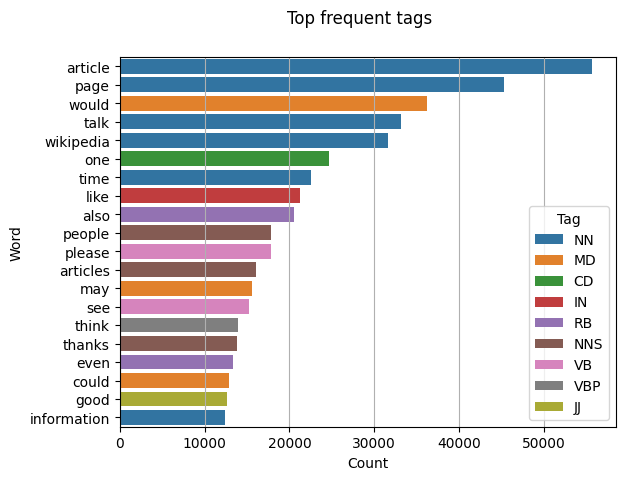

In [146]:
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x='Count', y='Word', hue='Tag', 
            data=POS_frequent_df.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

### Toxic Comments Data

In [149]:
toxic_POS_list = []

for x in processed_df['POS_tagging_flat'][((processed_df.toxic == 1) | (processed_df.severe_toxic == 1) | (processed_df.obscene == 1) | (processed_df.threat == 1) | (processed_df.identity_hate == 1))]:
    toxic_POS_list.append(x)

In [150]:
toxic_POS_count = Counter(chain(*toxic_POS_list))

In [152]:
toxic_POS_frequent_df = pd.DataFrame.from_dict(toxic_POS_count, orient='index').reset_index()
toxic_POS_frequent_df.columns = ['toxic_POS_tags', 'Count']
toxic_POS_frequent_df = toxic_POS_frequent_df.sort_values(by=['Count'], ascending=False)
toxic_POS_frequent_df['Word'] = toxic_POS_frequent_df['toxic_POS_tags'].apply(lambda x: x[0])
toxic_POS_frequent_df['Tag'] = toxic_POS_frequent_df['toxic_POS_tags'].apply(lambda x: x[1])

In [153]:
toxic_POS_frequent_df = toxic_POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
toxic_POS_frequent_df

,toxic_POS_tags,Count,Word,Tag
238,"(fuck, NN)",4723,fuck,NN
322,"(like, IN)",3314,like,IN
285,"(wikipedia, NN)",2811,wikipedia,NN
153,"(ass, NN)",2645,ass,NN
106,"(go, VB)",2474,go,VB
...,...,...,...,...
30815,"(control, VBN)",1,control,VBN
30814,"(cronies, NNS)",1,cronies,NNS
30813,"(unfortunatly, RB)",1,unfortunatly,RB
30812,"(fervant, JJ)",1,fervant,JJ


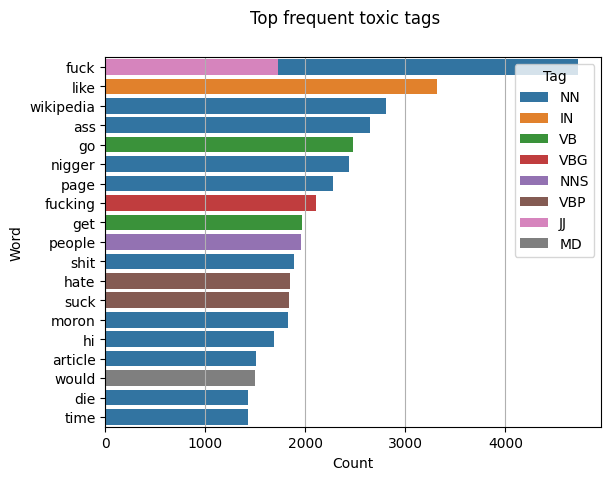

In [154]:
fig, ax = plt.subplots()
fig.suptitle("Top frequent toxic tags", fontsize=12)
sns.barplot(x='Count', y='Word', hue='Tag', 
            data=toxic_POS_frequent_df.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

### Non-Toxic Comments Data

In [156]:
nontoxic_POS_list = []

for x in processed_df['POS_tagging_flat'][((processed_df.toxic == 0) &(processed_df.severe_toxic == 0) & (processed_df.obscene == 0) & (processed_df.threat == 0) & (processed_df.identity_hate == 0))]:
    nontoxic_POS_list.append(x)

In [157]:
nontoxic_POS_count = Counter(chain(*nontoxic_POS_list))

In [158]:
nontoxic_POS_frequent_df = pd.DataFrame.from_dict(nontoxic_POS_count, orient='index').reset_index()
nontoxic_POS_frequent_df.columns = ['nontoxic_POS_tags', 'Count']
nontoxic_POS_frequent_df = nontoxic_POS_frequent_df.sort_values(by=['Count'], ascending=False)
nontoxic_POS_frequent_df['Word'] = nontoxic_POS_frequent_df['nontoxic_POS_tags'].apply(lambda x: x[0])
nontoxic_POS_frequent_df['Tag'] = nontoxic_POS_frequent_df['nontoxic_POS_tags'].apply(lambda x: x[1])

In [159]:
nontoxic_POS_frequent_df = nontoxic_POS_frequent_df.query("Word not in @stop_words & Word not in @list_punctuations")
nontoxic_POS_frequent_df

,nontoxic_POS_tags,Count,Word,Tag
184,"(article, NN)",54140,article,NN
39,"(page, NN)",43055,page,NN
203,"(would, MD)",34737,would,MD
38,"(talk, NN)",31826,talk,NN
163,"(wikipedia, NN)",28823,wikipedia,NN
...,...,...,...,...
152610,"(_departments_, VBP)",1,_departments_,VBP
152612,"(3.0.png, CD)",1,3.0.png,CD
152613,"(_3, JJ)",1,_3,JJ
152614,"(montgolfier, JJR)",1,montgolfier,JJR


## Weighted Words - Bag of Words (BoW) - Bag of n-grams

### Frequent Words Identification

In [134]:
from nltk.probability import FreqDist
def most_frequent_words(text):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)
    
    return df_fdist.head(50)

In [135]:
#identify frequent words
combined_toxic = ' '.join(processed_df['lemmatization'][((processed_df.toxic == 1) | (processed_df.severe_toxic == 1) | (processed_df.obscene == 1) | (processed_df.threat == 1) | (processed_df.identity_hate == 1))])

toxic_frequent = most_frequent_words(combined_toxic)
toxic_frequent['Punctuation'] = toxic_frequent['Word'].apply(lambda x: x in string.punctuation)
toxic_frequent = toxic_frequent[~toxic_frequent.Punctuation]
del toxic_frequent['Punctuation']

TypeError: sequence item 0: expected str instance, list found

In [136]:
#identify frequent words
combined_nontoxic = ' '.join(processed_df['lemmatization'][((processed_df.toxic == 0) &(processed_df.severe_toxic == 0) & (processed_df.obscene == 0) & (processed_df.threat == 0) & (processed_df.identity_hate == 0))])

nontoxic_frequent = most_frequent_words(combined_nontoxic)
nontoxic_frequent['Punctuation'] = nontoxic_frequent['Word'].apply(lambda x: x in string.punctuation)
nontoxic_frequent = nontoxic_frequent[~nontoxic_frequent.Punctuation]
del nontoxic_frequent['Punctuation']

TypeError: sequence item 0: expected str instance, list found

In [137]:
toxic_frequent.head()

NameError: name 'toxic_frequent' is not defined

In [138]:
nontoxic_frequent.head()

NameError: name 'nontoxic_frequent' is not defined

For toxic comments

In [ ]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(toxic_frequent['Word']))
plt.imshow(word_cloud)
plt.axis('off')
plt.title("Wordcloud for toxic comments")
plt.show()

For non toxic comment

In [ ]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(nontoxic_frequent['Word']))
plt.imshow(word_cloud)
plt.title("Wordcloud for non-toxic comments")
plt.axis('off')
plt.show()

### Frequency Vector

Bigrams frequency

In [ ]:
vec = CountVectorizer(ngram_range=(2, 2))
bow = vec.fit_transform(processed_df['text_tokenized'])
sum_of_words = bow.sum(axis=0)
bigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
bigrams_freq =sorted(bigrams_freq, key = lambda x: x[1], reverse=True)
bigrams_freq = pd.DataFrame(bigrams_freq[:50], columns=["bigrams", "frequency"])

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data = bigrams_freq, x = "frequency", y="bigrams")
plt.title("Bigrams frequency")

Trigrams frequency

In [ ]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(processed_df['text_tokenized'])
sum_of_words = bow.sum(axis=0)
trigrams_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
trigrams_freq =sorted(trigrams_freq, key = lambda x: x[1], reverse=True)
trigrams_freq = pd.DataFrame(trigrams_freq[:50], columns=["trigrams", "frequency"])

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data = trigrams_freq, x = "frequency", y="trigrams")
plt.title("Trigrams frequency")

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
# def TF_IDF(ngram, cleaned_df):
#     tfidf = TfidfVectorizer(ngram_range = (ngram, ngram))
#     weight_words = tfidf.fit_transform(cleaned_df['lemmatization'])
#     return pd.DataFrame(weight_words.toarray().transpose(), index=tfidf.get_feature_names_out())

In [ ]:
#uni_gram = TF_IDF(1, cleaned_df)
# uni_gram.to_csv("/TF_IDF_Unigram.csv")
# bi_gram = TF_IDF(2, cleaned_df)
# bi_gram.to_csv("/TF_IDF_Bigram.csv")
# tri_gram = TF_IDF(3, cleaned_df)
# tri_gram.to_csv("/TF_IDF_Trigram.csv")

<a id="featureengineering"></a>
# 4. Feature Engineering

## Word Embedding

There are some decisions we need to make:
- should stop words and punctuations be removed before embedding
- custom embeddings or pre-trained embeddings or embedding layer
- for pre-trained embeddings, which package to use: Word2Vec/GloVe, FastText, BERT
- the size of vector to represent each text
- word embedding or sentence embedding

In [ ]:
# for word embeddings
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

# for BERT
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# define a helper function to calculate the embedding vector of each text
def get_embeddings(vectors, text_df, generate_missing=False, k=25):
    embeddings = []
    for i in range(len(text_df)):
        text = text_df[i]
        # dealing with empty text
        if len(text)<1:
            return np.zeros(k)
        # generate randomized vectors for unseen words if generate_missing is True
        if generate_missing:
            vectorized = [vectors[word][:k] if word in vectors else np.random.rand(k) for word in text]
        # represent unseen words with 0 vector if generate_missing is False
        else:
            vectorized = [vectors[word][:k] if word in vectors else np.zeros(k) for word in text]
        # each text is represented by averaging the vectors of its constituent words
        length = len(vectorized)
        summed = np.sum(vectorized, axis=0)
        averaged = np.divide(summed, length)
        embeddings.append(averaged)
    return embeddings

In [ ]:
# define a helper function to calculate the embedding vector of each text
def get_embeddings(vectors, text, generate_missing=False, k=25):
    # dealing with empty text
    if len(text)<1:
        return np.zeros(k)
    # generate randomized vectors for unseen words if generate_missing is True
    if generate_missing:
        vectorized = [vectors[word][:k] if word in vectors else np.random.rand(k) for word in text]
    # represent unseen words with 0 vector if generate_missing is False
    else:
        vectorized = [vectors[word][:k] if word in vectors else np.zeros(k) for word in text]
    # each text is represented by averaging the vectors of its constituent words
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

### Global Vectors for Word Representation (GloVe)

Similar to Word2Vec method, each word is presented by a high dimension vector and trained based on the surrounding words over a huge corpus. Since our project works on Tweets, we apply a pre-trained word embedding trained over Twitter content (https://github.com/stanfordnlp/GloVe).

Advantages:
- It captures the position of the words in the text (syntactic)
- It captures meaning in the words (semantics)

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)
- It cannot capture out-of-vocabulary words from corpus

In [ ]:
# generate a word2vec file used for model building
glove_input_file = "D:/GoogleDownloads/BT4222/glove.twitter.27B/glove.twitter.27B.25d.txt"
word2vec_output_file = "glove.twitter.27B.25d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
# build a GloVe model
glove_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False) 

In [ ]:
# generate embedding vectors of size 25 using tokenized text (stop words and punctuation kept)
# side note: map function outperforms for loop
embeddings_glove = processed_df["text_tokenized"].map(lambda x: get_embeddings(glove_model, x))

In [ ]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_glove[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_glove[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

The difference among different labels is not very obvious.

In [ ]:
pd.DataFrame(embeddings_glove).to_csv('embeddings_glove.csv', index=False)

### FastText

Using FastText, each word, w, is represented as a bag of character n-gram. For example, given the word "introduce" and n = 3, FastText will produce the following representation composed of character tri-grams: < in, int, ntr, tro, rod, odu, duc, uce, ce > Note that the sequence, corresponding to the word here is different from the tri-gram "int" from the word introduce. Again, FastText is pre-trained on huge corpus (https://fasttext.cc/docs/en/english-vectors.html).

Advantages:
- Works for rare words, if their character n-grams which are still shared with other words
- Solves out of vocabulary words with n-gram in character level

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)

In [ ]:
# build a FastText model
start_time3 = time.time()
fasttext_path = "D:/GoogleDownloads/BT4222/crawl-300d-2M-subword/crawl-300d-2M-subword.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=30000000000) # load 30B most common words
print("--- %s seconds ---" % (time.time() - start_time3))

In [ ]:
# generate embedding vectors of size 25 using tokenized text (stop words and punctuation kept)
embeddings_fasttext = processed_df["text_tokenized"].map(lambda x: get_embeddings(fasttext_model, x))

In [ ]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

Difference in distribution among different labels is very slight.

In [ ]:
pd.DataFrame(embeddings_fasttext).to_csv('embeddings_fasttext.csv', index=False)

### Bidirectional Encoder Representations from Transformers (BERT)

While each word has a fixed representation under forementioned models regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. We use the BERT base model to create sentence embeddings.

Advantages:
-  It captures the meaning of the word from the text (incorporates context, handling polysemy)

Limitations:
- Computationally expensive
- It cannot capture out-of-vocabulary words from a corpus

In [ ]:
# define a helper function to calculate the embedding vector of each text
def get_BERT_embeddings(text, max_len=512): # BERT can only take up to 512 tokens
    # tokenize sentence with BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = tokenized_text[:max_len-2] # truncate overlength text
    # add special tokens
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    # map the token strings to their vocabulary indeces
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # create segment ID
    segments_ids = [1] * len(tokenized_text)
    # convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # fead the inputs into BERT model
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
    # use the average of the second last hidden layer of each token as sentence embedding
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0).numpy()
    return sentence_embedding

In [ ]:
# load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)# whether the model returns all hidden-states
# put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [ ]:
# prepare the input used for BERT model
sentence_tokenized = processed_df['text_tokenized'].map(lambda x: ' '.join(x))

In [ ]:
# generate embedding vectors (stop words and punctuation kept)
start_time4 = time.time()
embeddings_bert = sentence_tokenized.map(get_BERT_embeddings)
print("--- %s seconds ---" % (time.time() - start_time4))

In [ ]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_df[processed_df[label]==1].index.values
        li = list(map(lambda x: embeddings_bert[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_df[processed_df[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_bert[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [ ]:
pd.DataFrame(embeddings_bert).to_csv('embeddings_bert.csv', index=False)

## Curseword Detection

Refer to https://github.com/vzhou842/profanity-check to use as an indicator for curseword

In [ ]:
featured_df['curseWord'] =  featured_df['clean_text'].apply(lambda x: predict([x])[0])